In [1]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r1.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

In [2]:
pivot_index = list(df_raw.columns[0:23])   # accuracy 전까지
remove_items = {
    'drift_model', 
    'pruning', 
    'retrain', 
    'Gmax', 
    'Gmin', 
    'G_ratio', 
    'n_rep', 
    'device', 
    'noise_model',
    'dataset',
    'mapping_scaling_omega',
    'model_type',
    'lr',
    'epoch',
    }

pivot_index = [item for item in pivot_index if item not in remove_items]
pivot_index

['model',
 'IOparameter',
 'GDC',
 'pgm_noise_scale',
 'read_noise_scale',
 'drift_scale',
 'drift_var',
 'fix_seed',
 'inf_time']

In [17]:
df = df_raw.copy()

In [18]:
df = df[df['model']=='Resnet18']
df = df[df['pgm_noise_scale'] == 0]
df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']=='default']
# df = df[df['G_ratio']==25]
df = df[df['fix_seed']==42]

In [19]:
df_ideal_gdc = df[(df['IOparameter'] == 'ideal') & (df['GDC'] == 'on')]
df_ideal_gdcx = df[(df['IOparameter'] == 'ideal') & (df['GDC'] == 'off')]
df_nonideal_gdc = df[(df['IOparameter'] == 'non-ideal') & (df['GDC'] == 'on')]
df_nonideal_gdcx = df[(df['IOparameter'] == 'non-ideal') & (df['GDC'] == 'off')]

In [20]:
df['model_type'].unique()

array(['vanilla', '0.3_retrained', '0.4_retrained', '0.5_retrained',
       '0.6_retrained', '0.7_retrained', '0.3_pruned', '0.4_pruned',
       '0.5_pruned', '0.6_pruned', '0.7_pruned'], dtype=object)

In [21]:
df['lr'].unique()

array(['-', 0.0001, 0.0005, 1e-05, 5e-05, 1e-06], dtype=object)

In [8]:
df

,model,dataset,pruning,retrain,model_type,lr,epoch,device,IOparameter,GDC,...,Gmin,Gmax,G_ratio,fix_seed,n_rep,inf_time,.,accuracy,std,note
632,Resnet18,CIFAR10,-,-,vanilla,-,-,PCMPresetUnitCell,ideal,on,...,default,default,25,42,30,1,1 sec,93.070000,0.01,NaN
633,Resnet18,CIFAR10,-,-,vanilla,-,-,PCMPresetUnitCell,ideal,on,...,default,default,25,42,30,60,1 min,92.890000,0.05,NaN
634,Resnet18,CIFAR10,-,-,vanilla,-,-,PCMPresetUnitCell,ideal,on,...,default,default,25,42,30,100,-,92.810000,0.06,NaN
635,Resnet18,CIFAR10,-,-,vanilla,-,-,PCMPresetUnitCell,ideal,on,...,default,default,25,42,30,3600,1 hour,91.900000,0.17,NaN
636,Resnet18,CIFAR10,-,-,vanilla,-,-,PCMPresetUnitCell,ideal,on,...,default,default,25,42,30,86400,1 day,90.400000,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,Resnet18,CIFAR10,0.7,O,0.7_retrained,0.0001,30,PCMPresetUnitCell,ideal,off,...,default,default,25,42,30,86400,1 day,80.804667,0.737278,NaN
1854,Resnet18,CIFAR10,0.7,O,0.7_retrained,0.0001,30,PCMPresetUnitCell,ideal,off,...,default,default,25,42,30,2592000,1 month,60.812333,1.519876,NaN
1855,Resnet18,CIFAR10,0.7,O,0.7_retrained,0.0001,30,PCMPresetUnitCell,ideal,off,...,default,default,25,42,30,31104000,1 year,41.212000,2.008104,NaN
1856,Resnet18,CIFAR10,0.7,O,0.7_retrained,0.0001,30,PCMPresetUnitCell,ideal,off,...,default,default,25,42,30,93312000,3 year,33.439333,1.869747,NaN


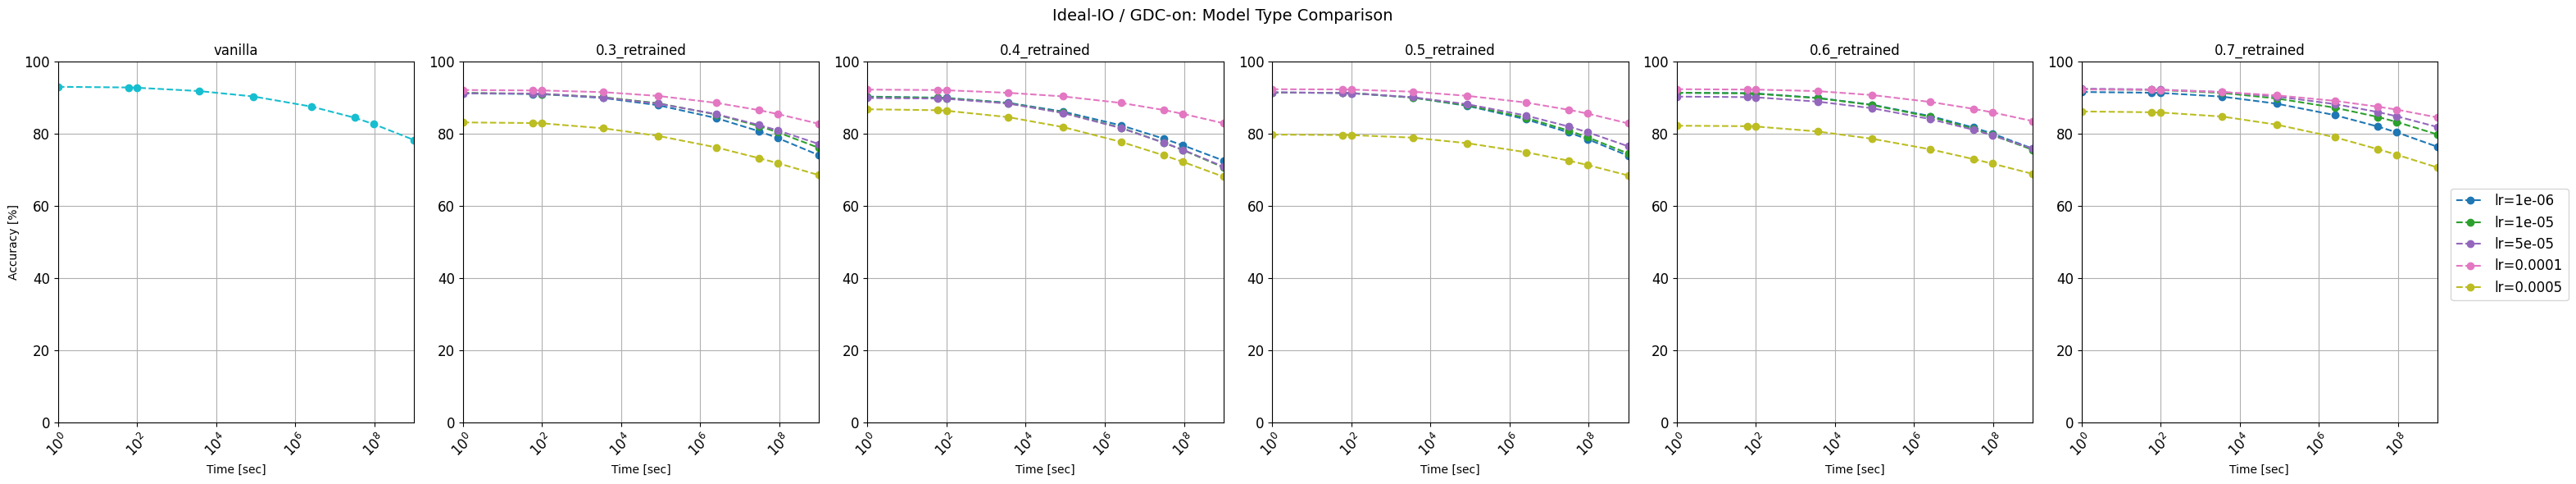

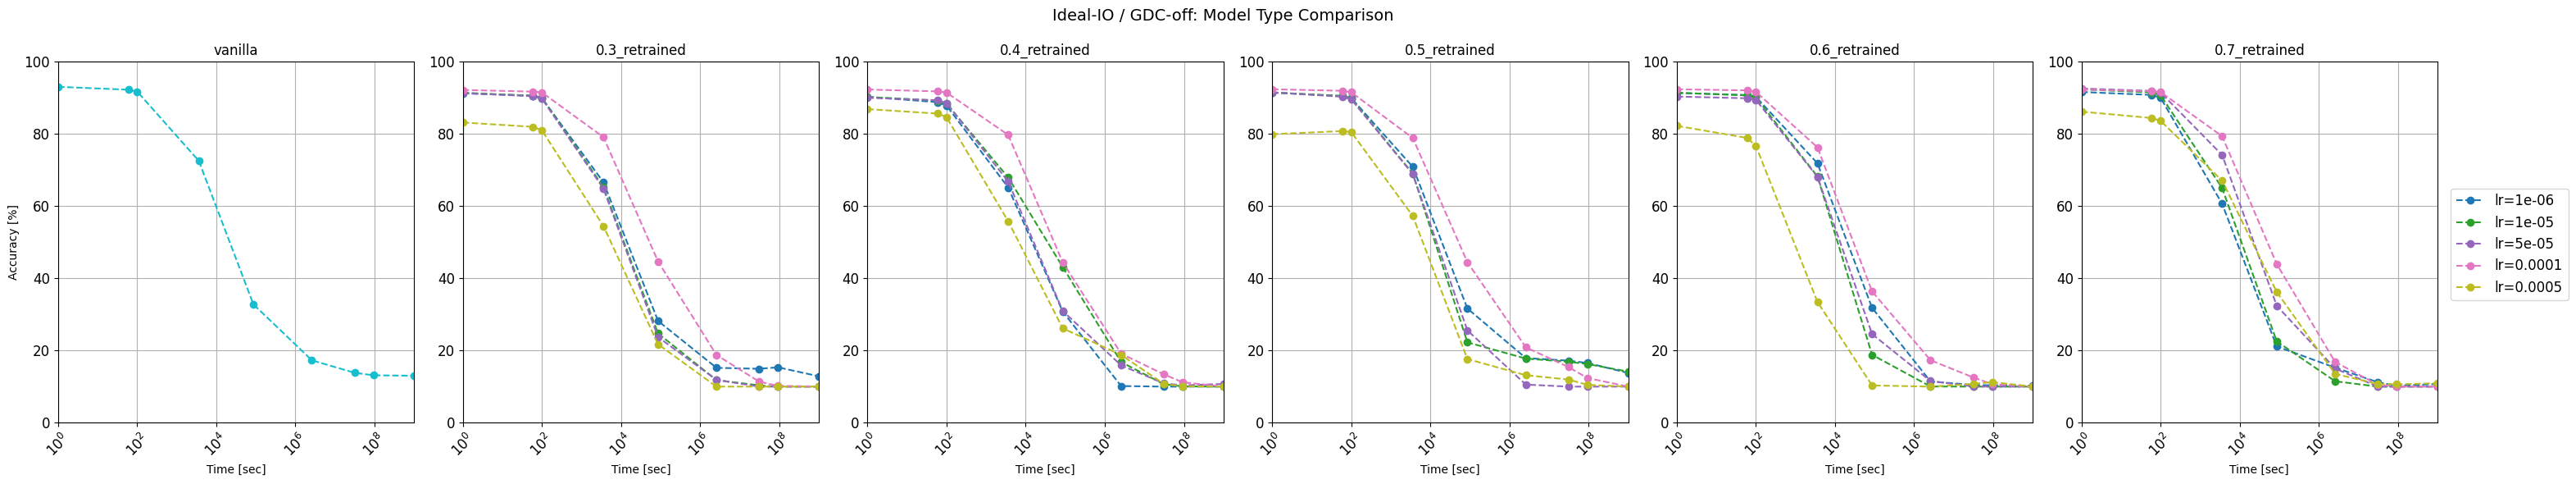

In [24]:
import matplotlib.pyplot as plt

def plot_model_types(df_filtered, title):
    # Create subplot grid (1 row, 6 columns for each model type)
    fig, axes = plt.subplots(1, 6, figsize=(30, 6))
    plt.rcParams.update({'font.size': 12})

    # Common settings
    model_types = ['vanilla', '0.3_retrained', '0.4_retrained', 
                  '0.5_retrained', '0.6_retrained', '0.7_retrained']
    # Handle lr values with custom sorting
    lr_values = df_filtered['lr'].unique()
    lr_values = sorted([x for x in lr_values if x != '-']) + ['-']
    colors = plt.cm.tab10(np.linspace(0, 1, len(lr_values)))

    # Plot each model type in separate subplot
    for ax, model_type in zip(axes, model_types):
        mask_model = df_filtered['model_type'] == model_type
        
        for lr, color in zip(lr_values, colors):
            mask = mask_model & (df_filtered['lr'] == lr)
            if len(df_filtered[mask]) > 0:
                ax.plot(df_filtered[mask]['inf_time'], 
                       df_filtered[mask]['accuracy'],
                       label=f'lr={lr}', color=color, 
                       marker='o', linestyle='--')
        
        ax.set_title(f'{model_type}', fontsize=12)
        ax.set_xlabel('Time [sec]', fontsize=10)
        if ax == axes[0]:
            ax.set_ylabel('Accuracy [%]', fontsize=10)
        ax.set_xscale('log')
        ax.grid(True)
        ax.set_ylim(0, 100)
        ax.set_xlim(1, 1e9)
        ax.tick_params(axis='x', rotation=45)

    # Single legend for all subplots
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
              bbox_to_anchor=(1.05, 0.5))

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Create plots for each condition
plot_model_types(df_ideal_gdc, 'Ideal-IO / GDC-on: Model Type Comparison')
plot_model_types(df_ideal_gdcx, 'Ideal-IO / GDC-off: Model Type Comparison')

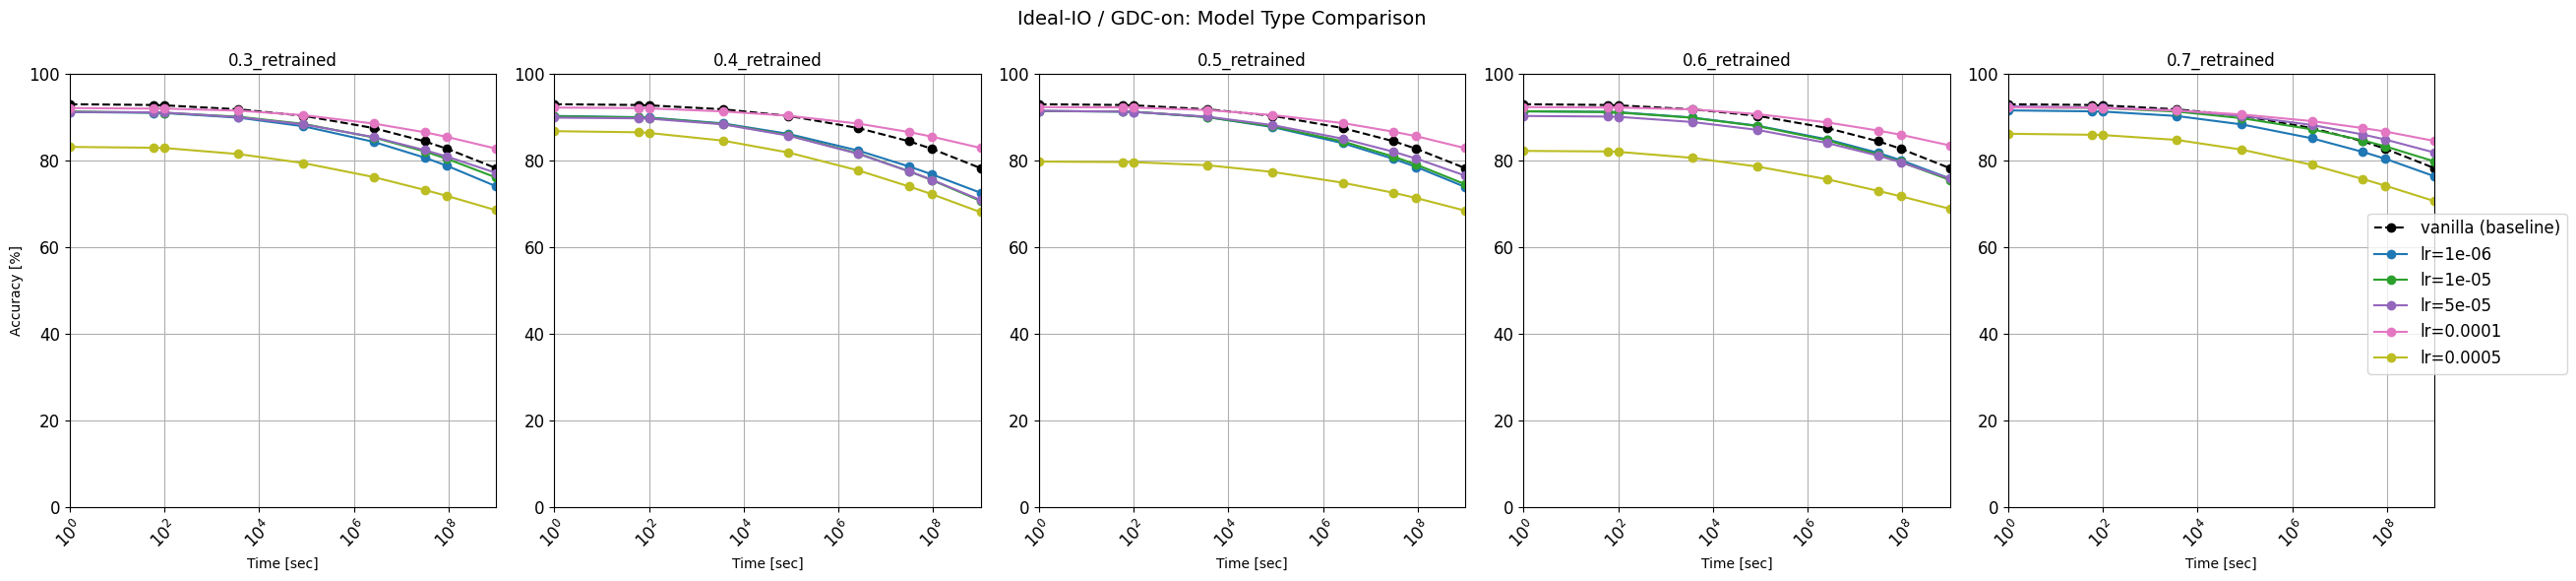

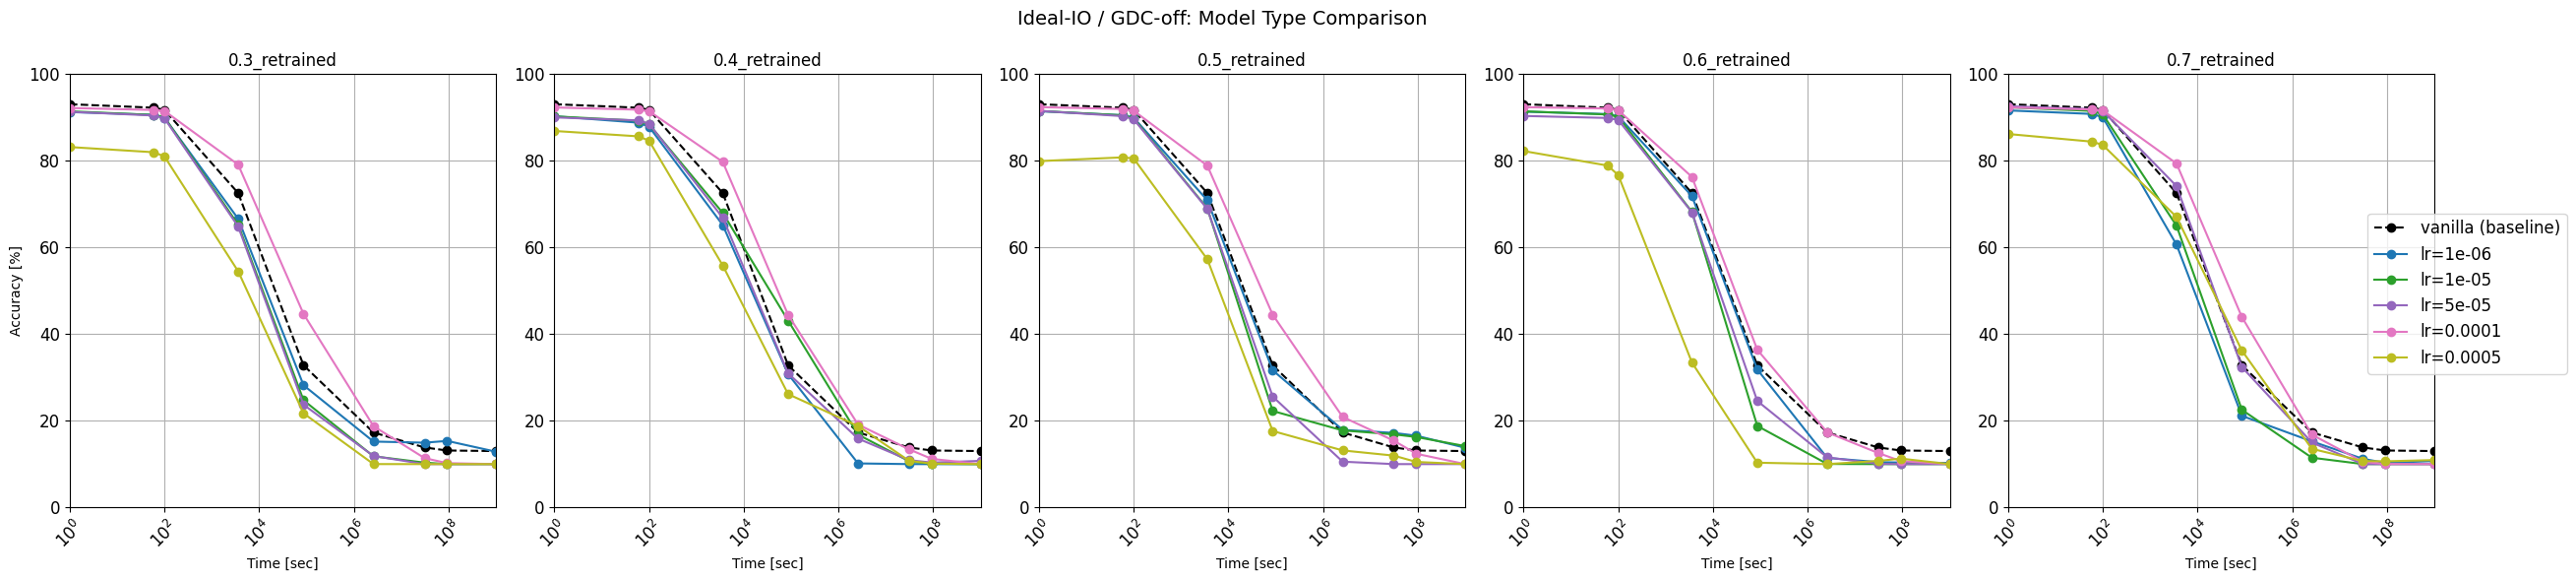

In [26]:
def plot_model_types(df_filtered, title):
    # Create subplot grid (1 row, 5 columns - excluding vanilla from separate column)
    fig, axes = plt.subplots(1, 5, figsize=(25, 6))
    plt.rcParams.update({'font.size': 12})

    # Common settings
    model_types = ['0.3_retrained', '0.4_retrained', 
                  '0.5_retrained', '0.6_retrained', '0.7_retrained']
    lr_values = df_filtered['lr'].unique()
    lr_values = sorted([x for x in lr_values if x != '-']) + ['-']
    colors = plt.cm.tab10(np.linspace(0, 1, len(lr_values)))

    # Get vanilla data once
    vanilla_mask = df_filtered['model_type'] == 'vanilla'
    vanilla_data = df_filtered[vanilla_mask]

    # Plot each model type in separate subplot
    for ax, model_type in zip(axes, model_types):
        # Plot vanilla as baseline first (dashed black line)
        ax.plot(vanilla_data['inf_time'], vanilla_data['accuracy'],
                label='vanilla (baseline)', color='black', 
                marker='o', linestyle='--', alpha=1)
        
        mask_model = df_filtered['model_type'] == model_type
        for lr, color in zip(lr_values, colors):
            mask = mask_model & (df_filtered['lr'] == lr)
            if len(df_filtered[mask]) > 0:
                ax.plot(df_filtered[mask]['inf_time'], 
                       df_filtered[mask]['accuracy'],
                       label=f'lr={lr}', color=color, 
                       marker='o', linestyle='-')
        
        ax.set_title(f'{model_type}', fontsize=12)
        ax.set_xlabel('Time [sec]', fontsize=10)
        if ax == axes[0]:
            ax.set_ylabel('Accuracy [%]', fontsize=10)
        ax.set_xscale('log')
        ax.grid(True)
        ax.set_ylim(0, 100)
        ax.set_xlim(1, 1e9)
        ax.tick_params(axis='x', rotation=45)

    # Single legend for all subplots
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
              bbox_to_anchor=(1.05, 0.5))

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Create plots for each condition
plot_model_types(df_ideal_gdc, 'Ideal-IO / GDC-on: Model Type Comparison')
plot_model_types(df_ideal_gdcx, 'Ideal-IO / GDC-off: Model Type Comparison')

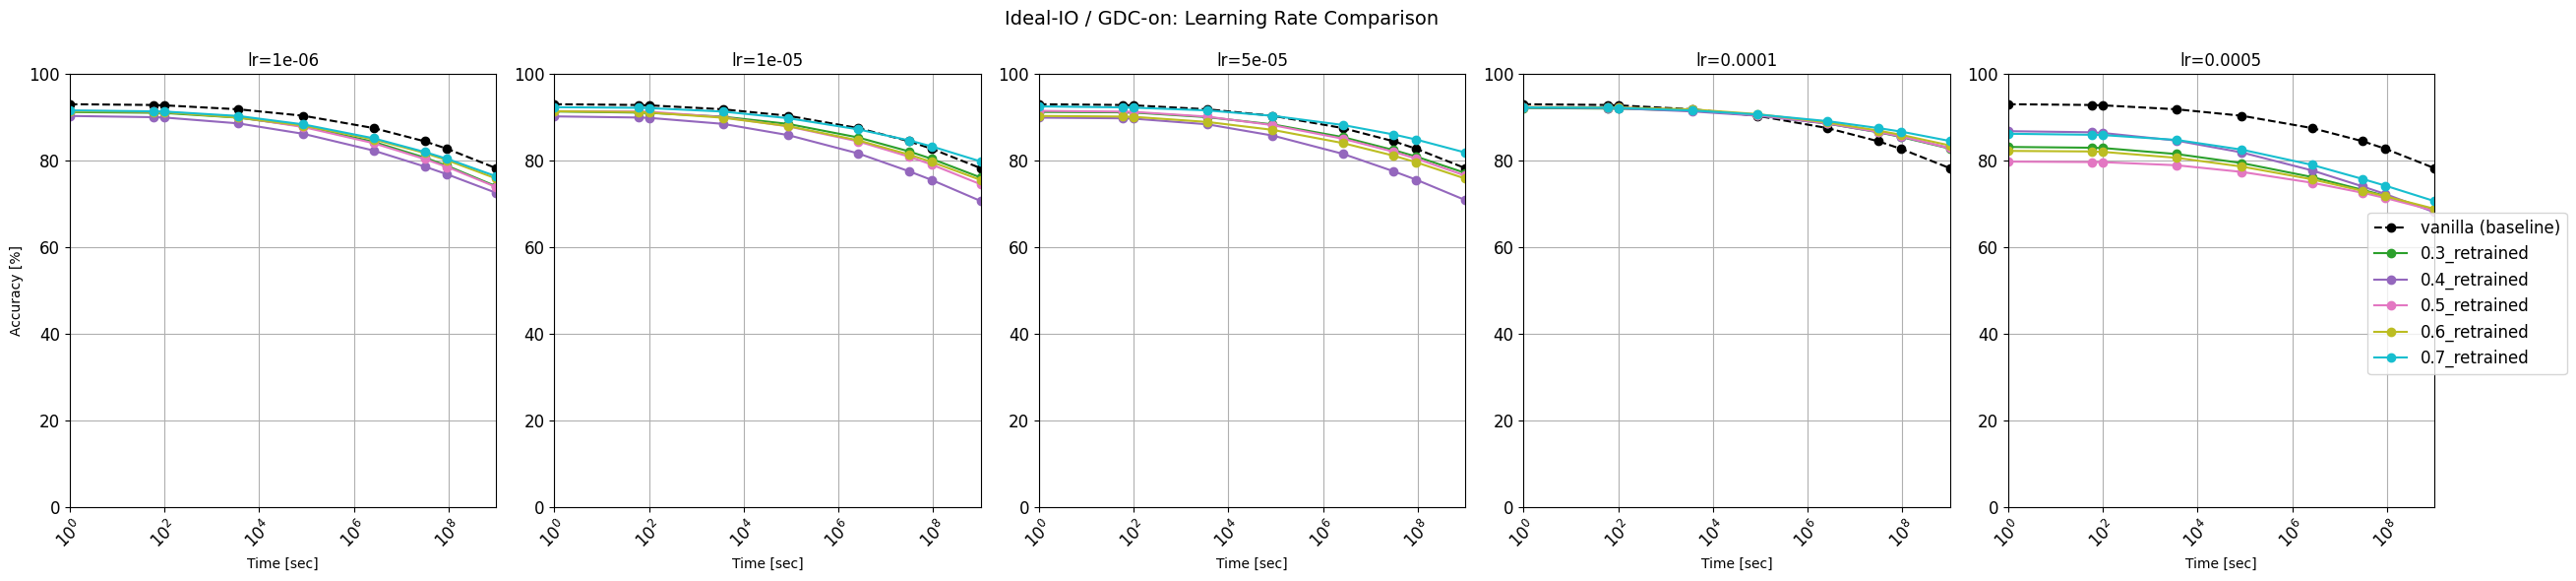

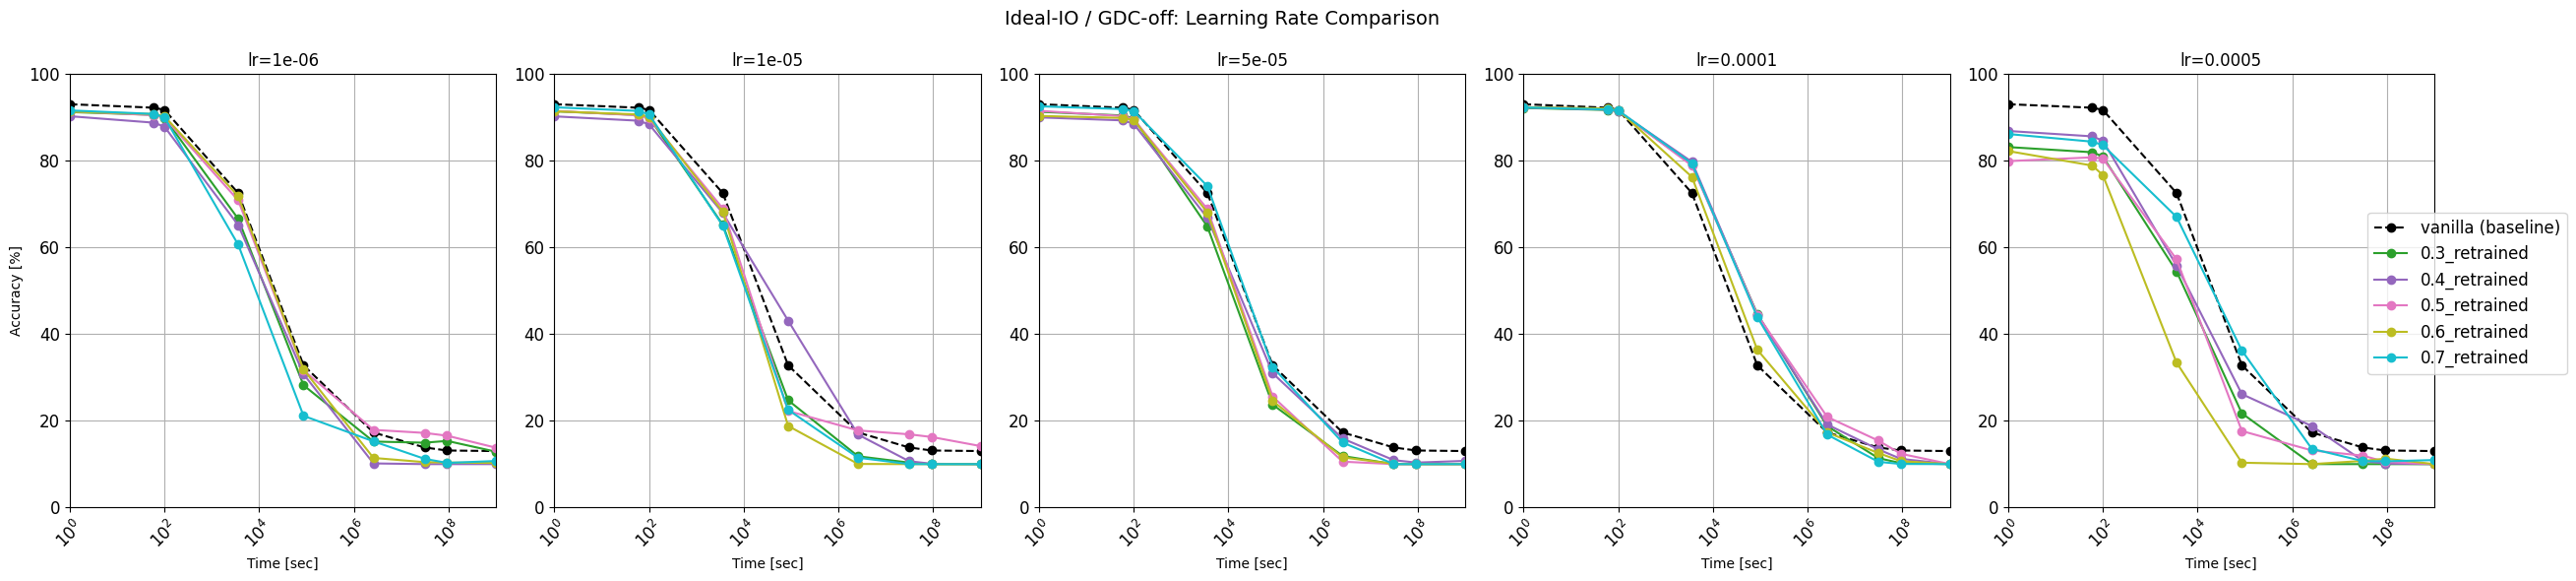

In [28]:
def plot_lr_types(df_filtered, title):
    # Create subplot grid (1 row, N columns for each lr value)
    lr_values = sorted([x for x in df_filtered['lr'].unique() if x != '-'])  # Exclude '-' from columns
    fig, axes = plt.subplots(1, len(lr_values), figsize=(25, 6))
    plt.rcParams.update({'font.size': 12})

    # Common settings
    model_types = ['vanilla', '0.3_retrained', '0.4_retrained', 
                  '0.5_retrained', '0.6_retrained', '0.7_retrained']
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_types)))
    
     # Get vanilla data once
    vanilla_mask = df_filtered['model_type'] == 'vanilla'
    vanilla_data = df_filtered[vanilla_mask]

    # Plot each learning rate in separate subplot
    for ax, lr in zip(axes, lr_values):
        mask_lr = df_filtered['lr'] == lr
        
        ax.plot(vanilla_data['inf_time'], vanilla_data['accuracy'],
                label='vanilla (baseline)', color='black', 
                marker='o', linestyle='--', alpha=1)
        
        for model_type, color in zip(model_types, colors):
            mask = mask_lr & (df_filtered['model_type'] == model_type)
            if len(df_filtered[mask]) > 0:
                ax.plot(df_filtered[mask]['inf_time'], 
                       df_filtered[mask]['accuracy'],
                       label=model_type, color=color, 
                       marker='o', linestyle='-')
        
        ax.set_title(f'lr={lr}', fontsize=12)
        ax.set_xlabel('Time [sec]', fontsize=10)
        if ax == axes[0]:
            ax.set_ylabel('Accuracy [%]', fontsize=10)
        ax.set_xscale('log')
        ax.grid(True)
        ax.set_ylim(0, 100)
        ax.set_xlim(1, 1e9)
        ax.tick_params(axis='x', rotation=45)

    # Single legend for all subplots
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
              bbox_to_anchor=(1.05, 0.5))

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Create plots for each condition
plot_lr_types(df_ideal_gdc, 'Ideal-IO / GDC-on: Learning Rate Comparison')
plot_lr_types(df_ideal_gdcx, 'Ideal-IO / GDC-off: Learning Rate Comparison')

In [24]:
df_o_o_pivot = df_ideal_gdc.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_o_o_pivot.reset_index(inplace=True) # index to columns 

df_o_x_pivot = df_ideal_gdcx.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_o_x_pivot.reset_index(inplace=True) # index to columns 

df_x_o_pivot = df_nonideal_gdc.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_x_o_pivot.reset_index(inplace=True) # index to columns 

df_x_x_pivot = df_nonideal_gdcx.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_x_x_pivot.reset_index(inplace=True) # index to columns 

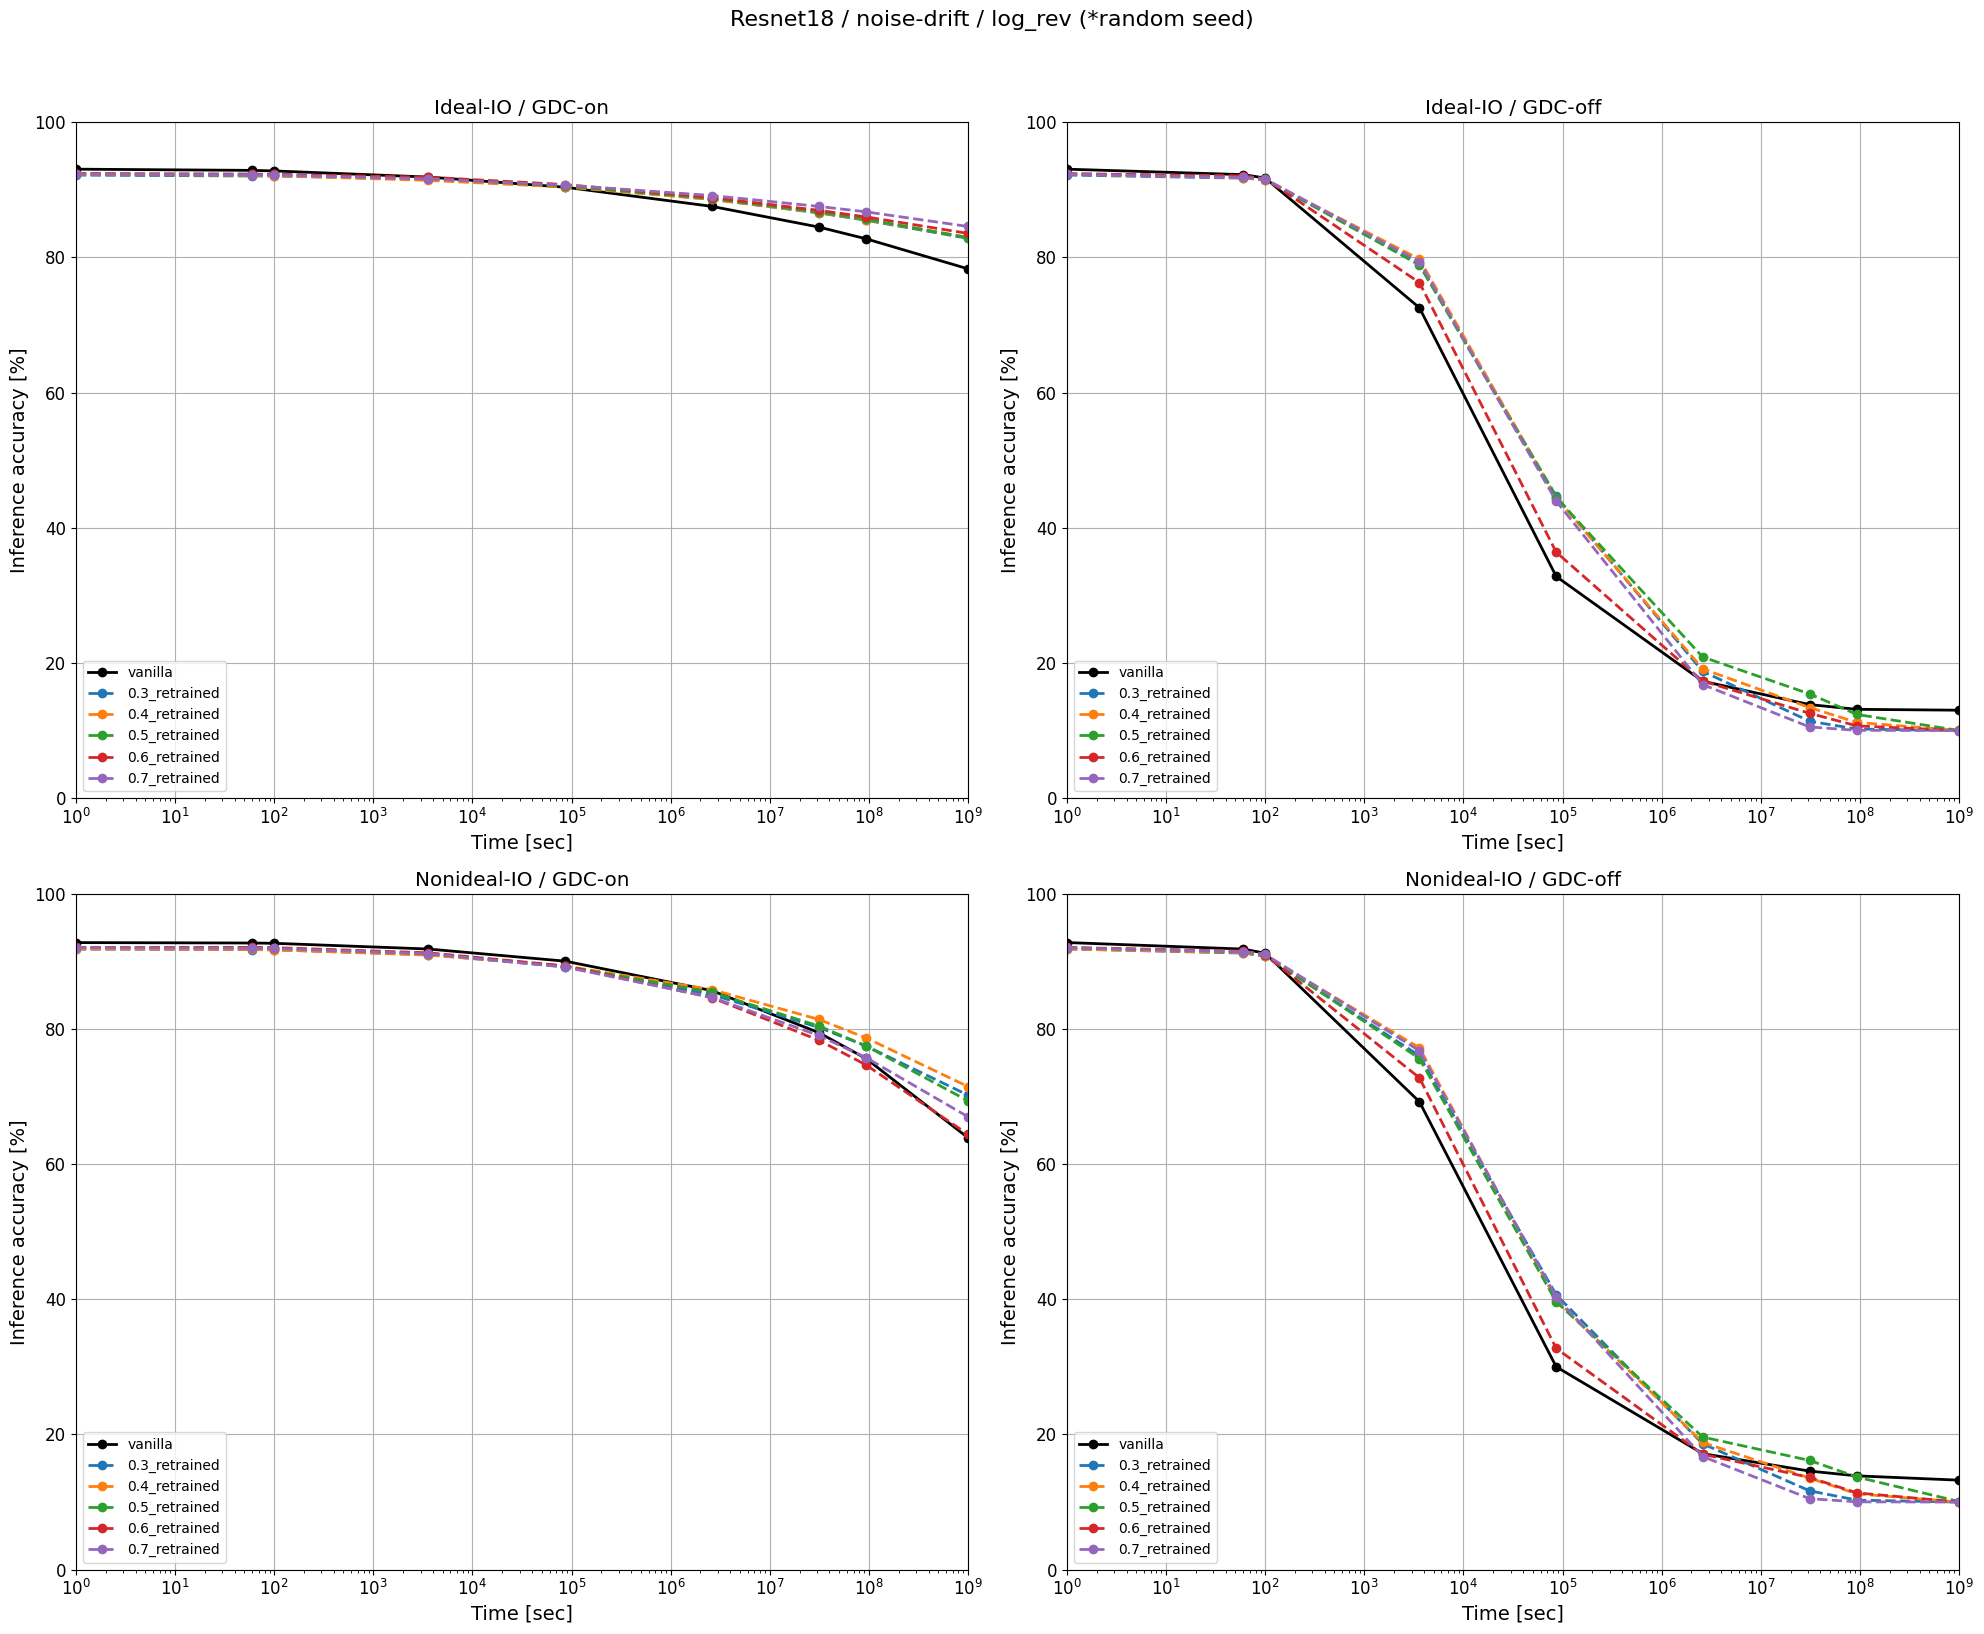

In [27]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

# Common plotting function
def plot_accuracy_re(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")


plt.suptitle("Resnet18 / noise-drift / log_rev (*random seed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

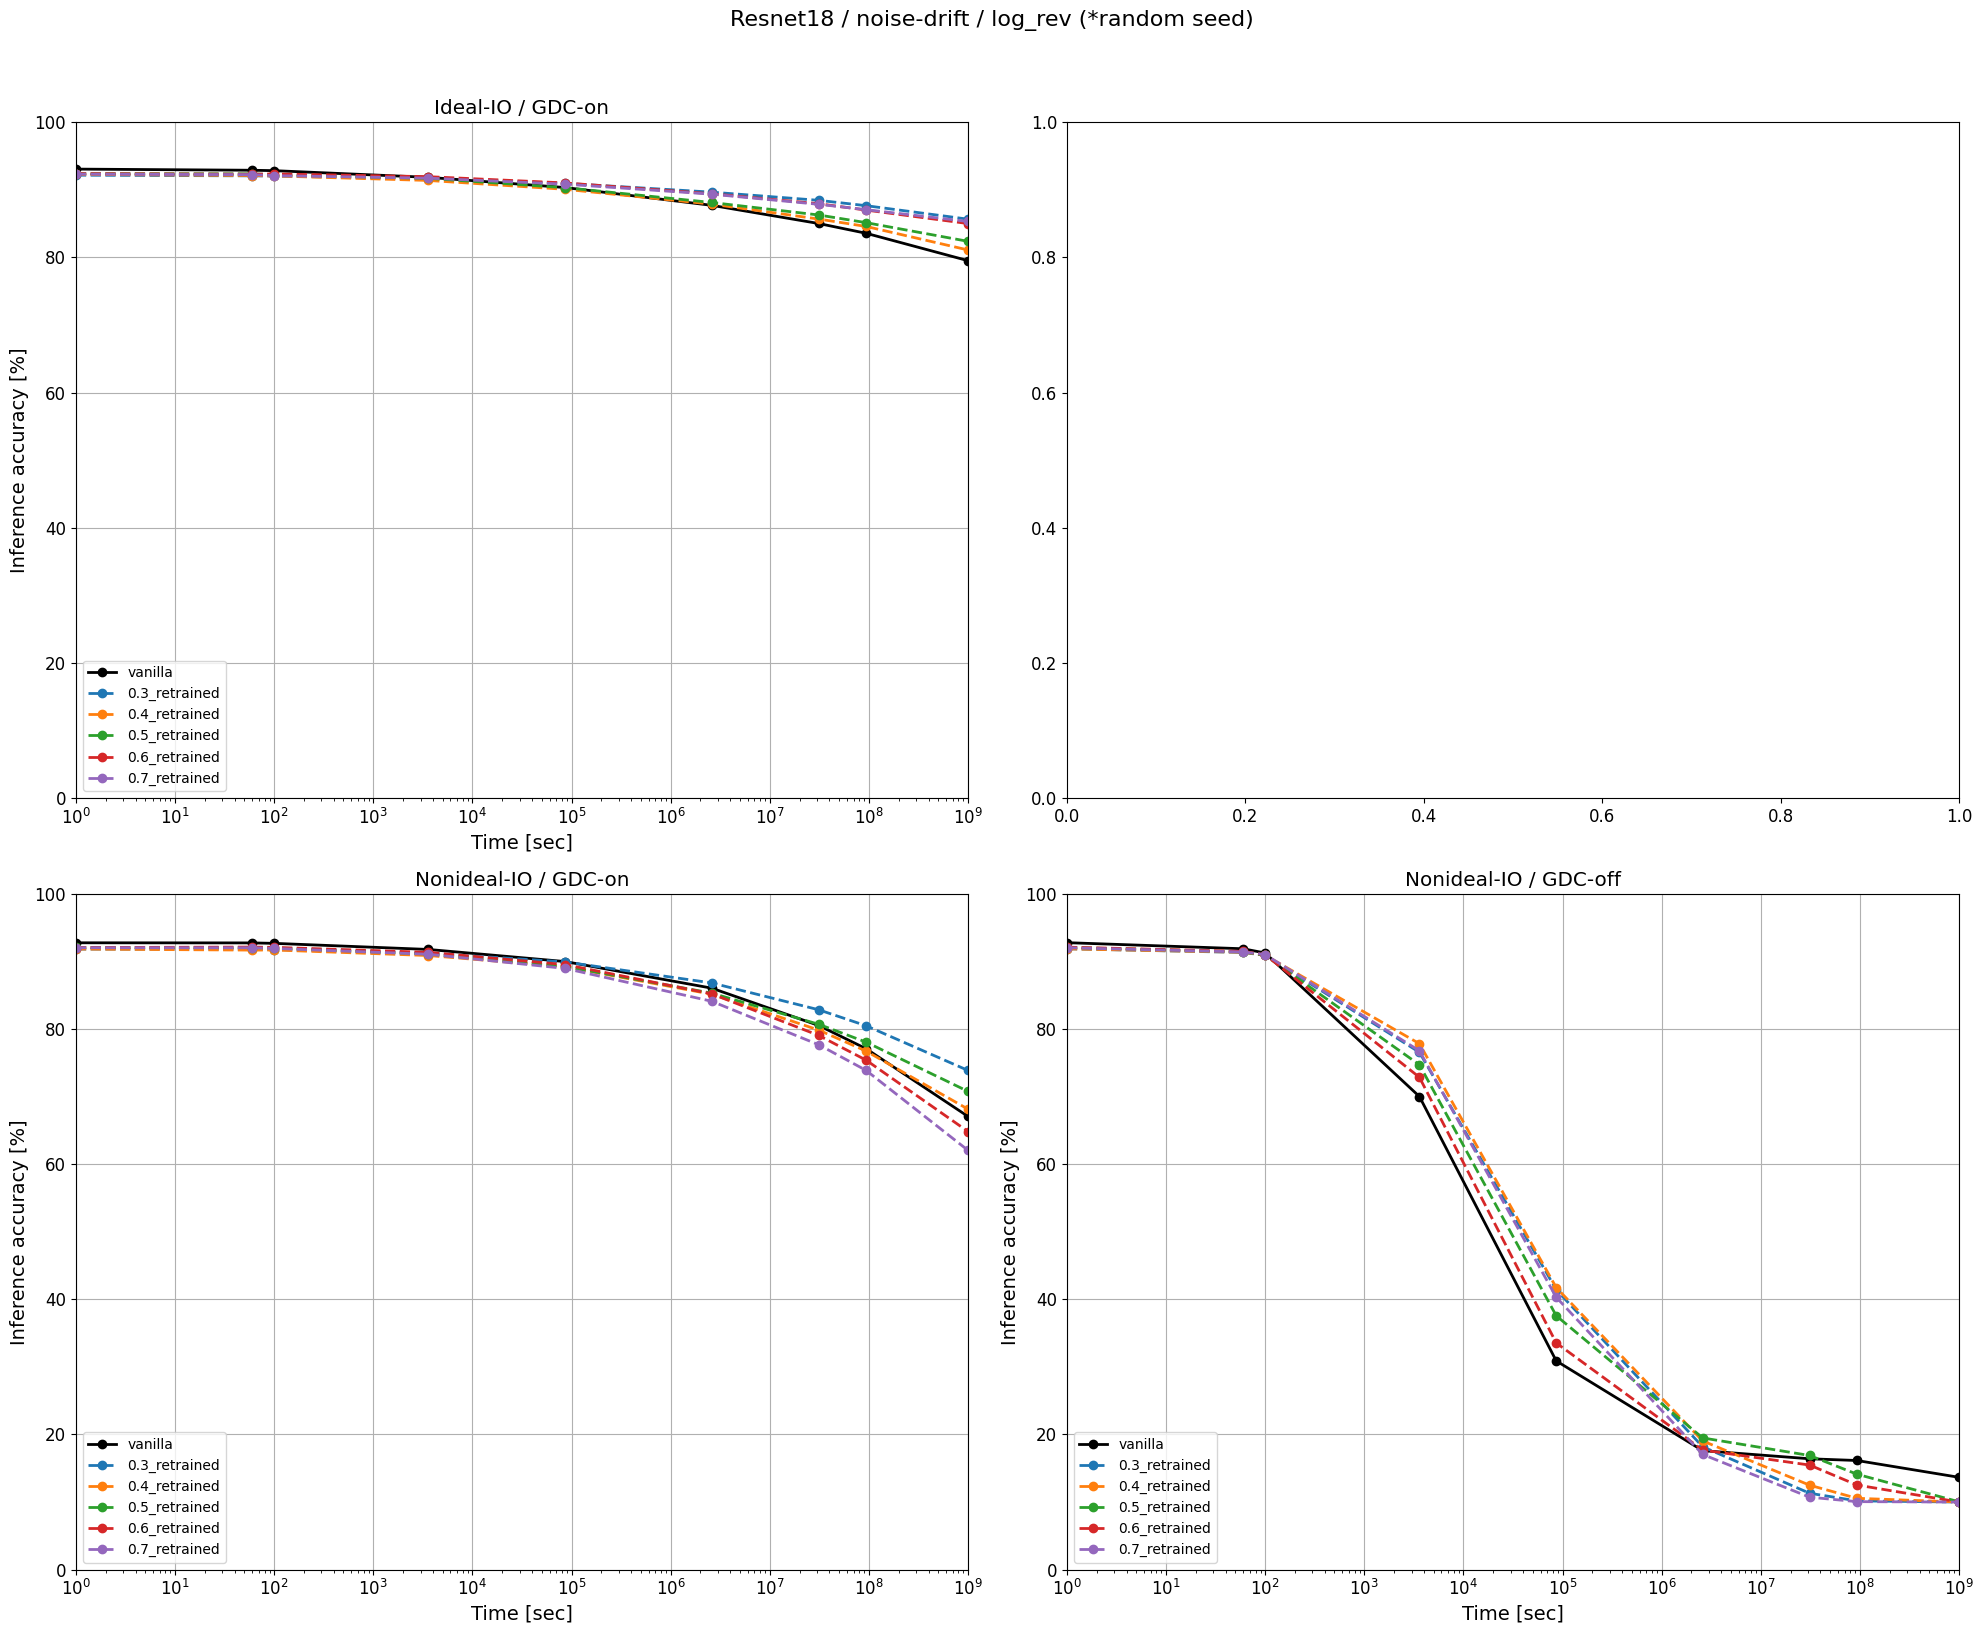

In [53]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

def plot_accuracy(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    # Plot pruned models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_pruned'], marker='^', 
                label=f'{ratio}_pruned', linestyle=':', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
# plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")

plt.suptitle("Resnet18 / noise-drift / log_rev (*random seed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

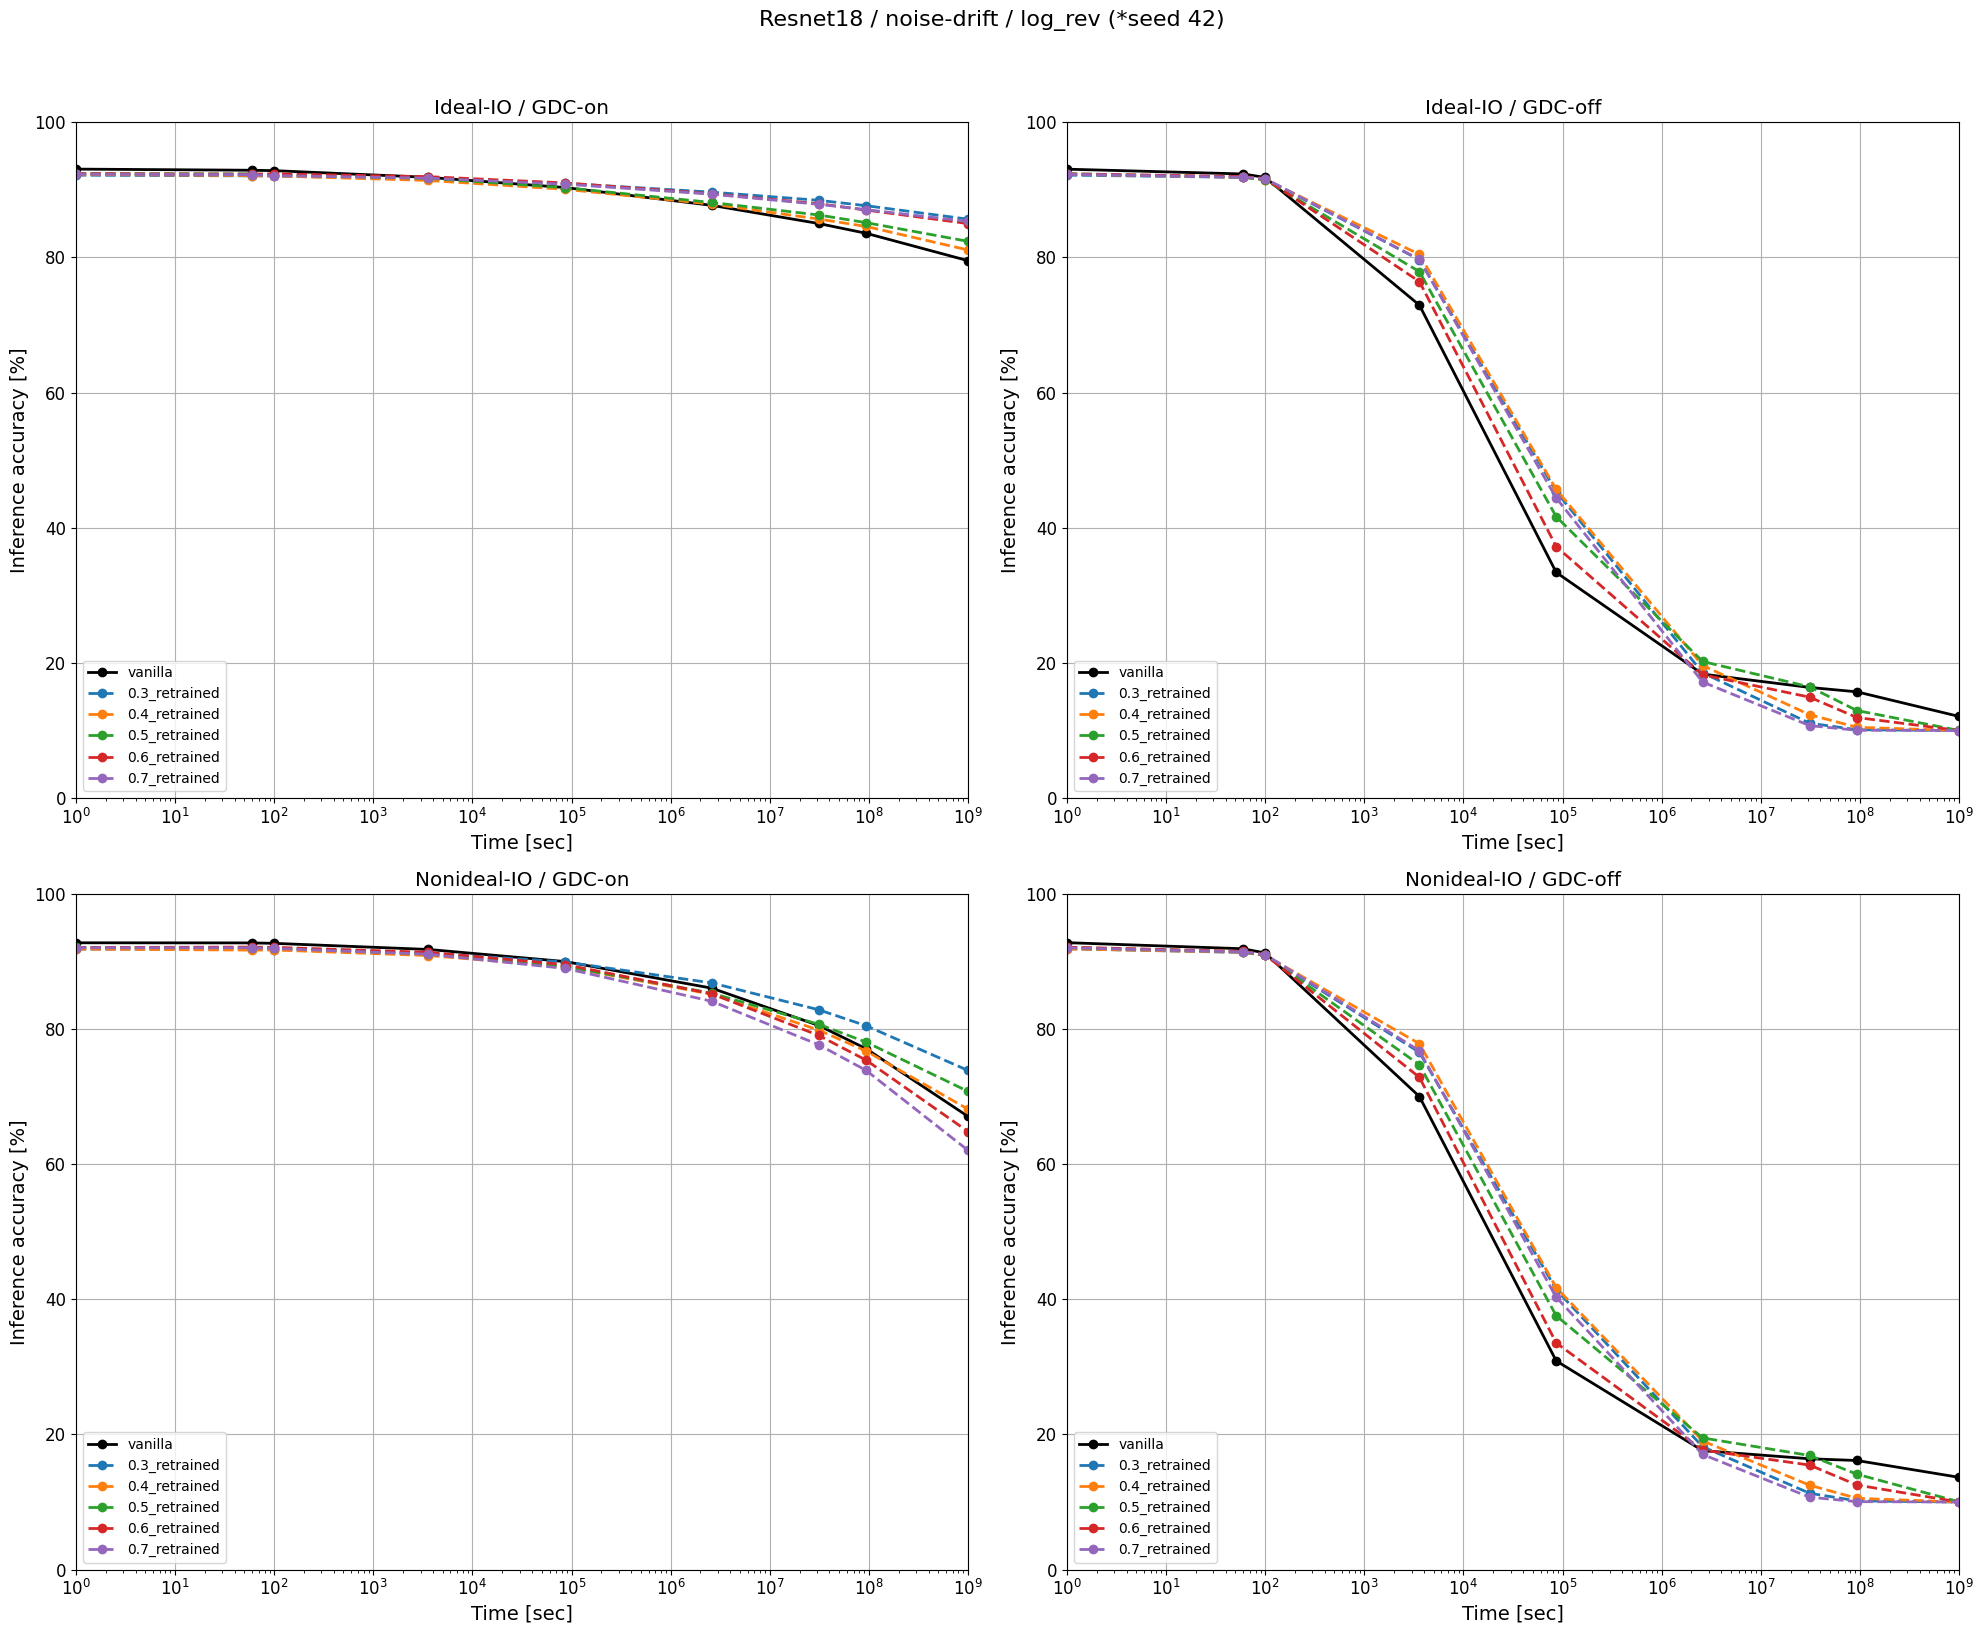

In [61]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

def plot_accuracy_re(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    # # Plot pruned models
    # for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
    #     ax.plot(x, df_pivot[f'{ratio}_pruned'], marker='^', 
    #             label=f'{ratio}_pruned', linestyle=':', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")

plt.suptitle("Resnet18 / noise-drift / log_rev (*seed 42)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

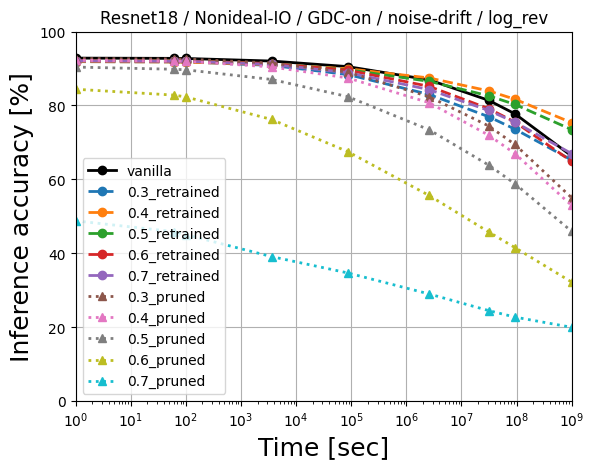

In [ ]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)

plt.plot(x,df_pivot['0.3_pruned'], marker='^', label = '0.3_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.4_pruned'], marker='^', label = '0.4_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.5_pruned'], marker='^', label = '0.5_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.6_pruned'], marker='^', label = '0.6_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.7_pruned'], marker='^', label = '0.7_pruned', linestyle=':', linewidth=2)


plt.title("Resnet18 / Nonideal-IO / GDC-on / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

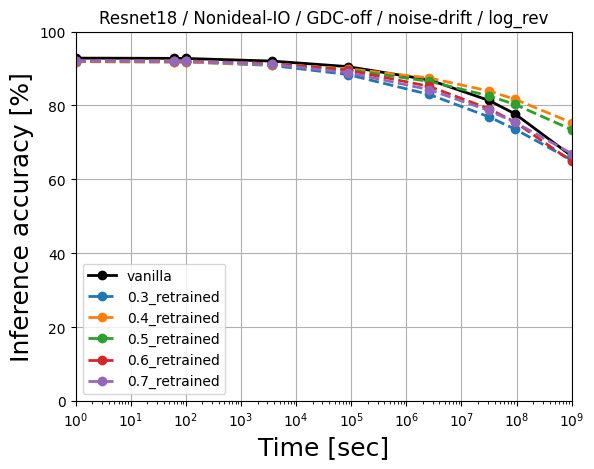

In [59]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / Nonideal-IO / GDC-off / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

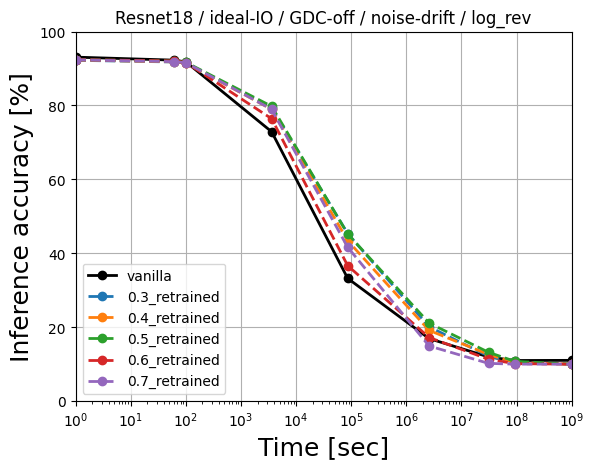

In [49]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / ideal-IO / GDC-off / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

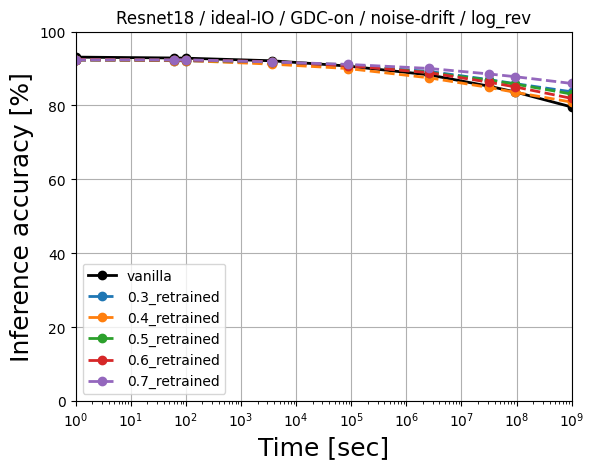

In [71]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / ideal-IO / GDC-on / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

In [48]:
df2 = df_raw.copy()

In [49]:
# df = df[df['drift_model'] == 0.01]
df2 = df2[df2['Gmin']=='default']
df2 = df2[df2['fix_seed']==42]
df2 = df2[(df2['lr']==1e-4) | (df2['lr']=='-')]

In [50]:
df2['drift_model'].unique()

array(['log_rev', 'test1', 'test2', 'test3', 'test4', 'test5'],
      dtype=object)

In [51]:
df2['new_col'] = df2['model_type'].astype(str) + '_' + df2['drift_model'].astype(str) 
df2['new_col'].unique()

array(['vanilla_log_rev', '0.3_retrained_log_rev',
       '0.4_retrained_log_rev', '0.5_retrained_log_rev',
       '0.6_retrained_log_rev', '0.7_retrained_log_rev',
       '0.3_pruned_log_rev', '0.4_pruned_log_rev', '0.5_pruned_log_rev',
       '0.6_pruned_log_rev', '0.7_pruned_log_rev', 'vanilla_test1',
       '0.3_retrained_test1', '0.4_retrained_test1',
       '0.5_retrained_test1', '0.6_retrained_test1',
       '0.7_retrained_test1', 'vanilla_test2', '0.3_retrained_test2',
       '0.4_retrained_test2', '0.5_retrained_test2',
       '0.6_retrained_test2', '0.7_retrained_test2', 'vanilla_test3',
       '0.3_retrained_test3', '0.4_retrained_test3',
       '0.5_retrained_test3', '0.6_retrained_test3',
       '0.7_retrained_test3', 'vanilla_test4', '0.3_retrained_test4',
       '0.4_retrained_test4', '0.5_retrained_test4',
       '0.6_retrained_test4', '0.7_retrained_test4', 'vanilla_test5',
       '0.3_retrained_test5', '0.4_retrained_test5',
       '0.5_retrained_test5', '0.6_retraine

In [52]:
df2_ideal_gdc = df2[(df2['IOparameter'] == 'ideal') & (df2['GDC'] == 'on')]
df2_ideal_gdcx = df2[(df2['IOparameter'] == 'ideal') & (df2['GDC'] == 'off')]

In [53]:
df2_o_o_pivot = df2_ideal_gdc.pivot_table(index=pivot_index, columns='new_col', values='accuracy', aggfunc='mean')
df2_o_o_pivot.reset_index(inplace=True) # index to columns 

df2_o_x_pivot = df2_ideal_gdcx.pivot_table(index=pivot_index, columns='new_col', values='accuracy', aggfunc='mean')
df2_o_x_pivot.reset_index(inplace=True) # index to columns 

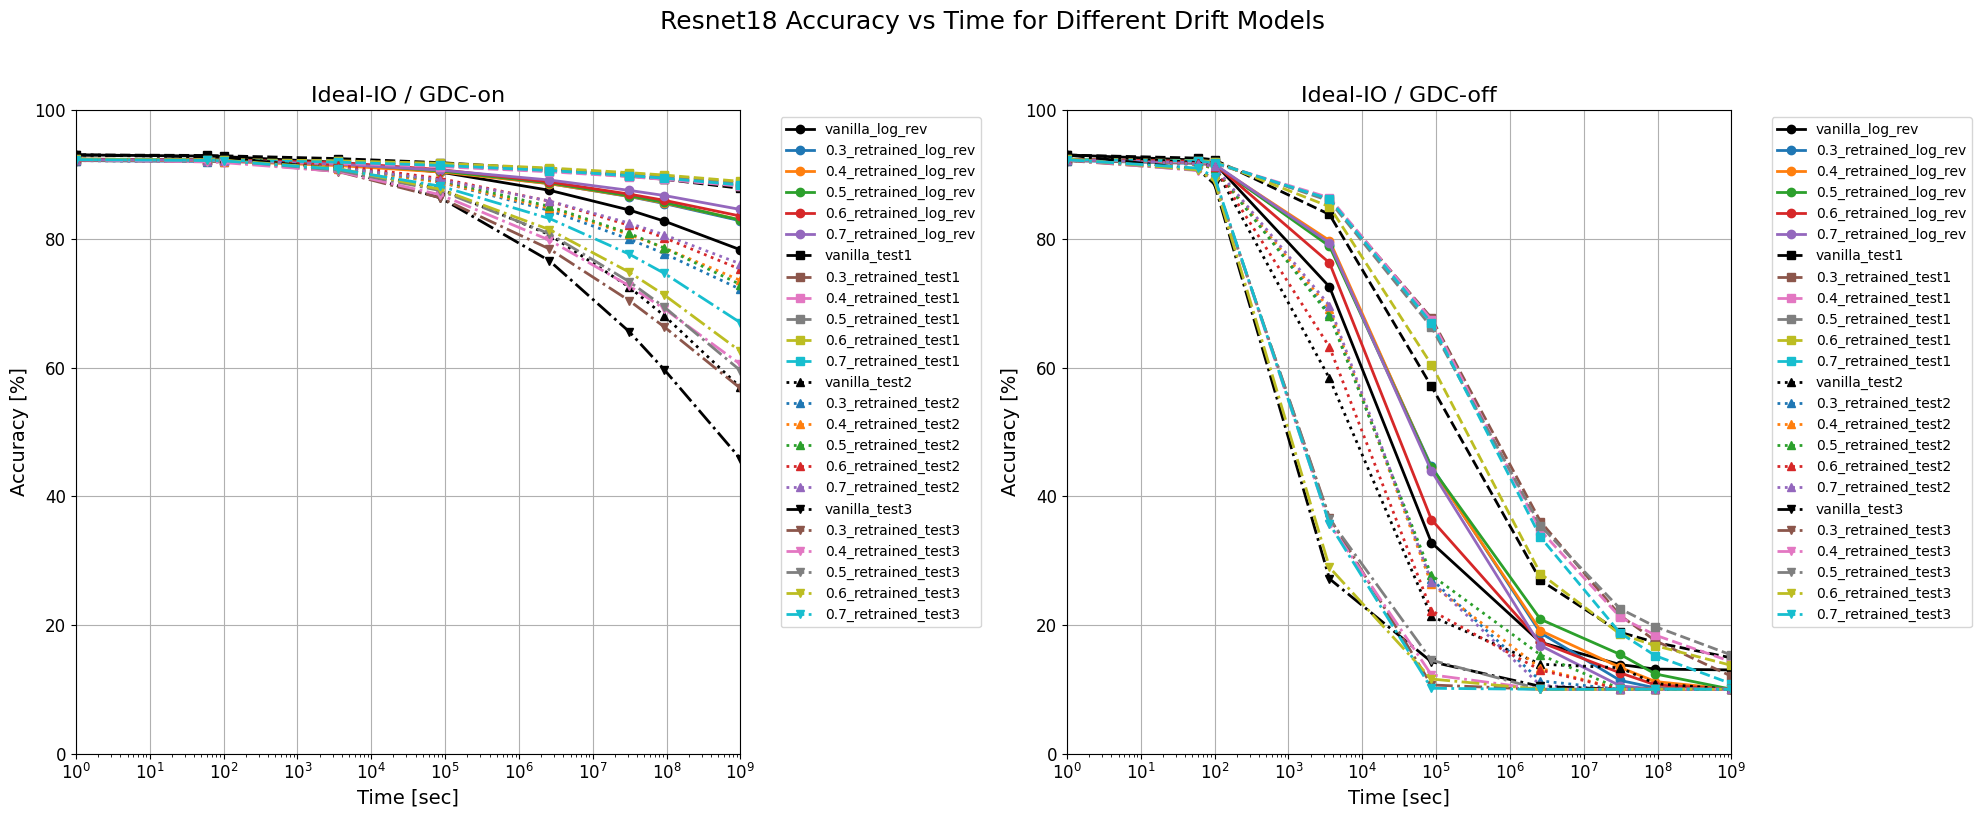

In [41]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plt.rcParams.update({'font.size': 12})

# Common plotting function
def plot_drift_models(ax, df_pivot, title):
    x = df_pivot['inf_time']
    drift_models = ['log_rev', 'test1', 'test2', 'test3']  
    linestyles = ['-', '--', ':', '-.']  
    markers = ['o', 's', '^', 'v'] 
    
    for drift_model, ls, marker in zip(drift_models, linestyles, markers):
        # Plot vanilla
        col_name = f'vanilla_{drift_model}'
        ax.plot(x, df_pivot[col_name], 
                label=col_name, color='black',
                linestyle=ls, marker=marker, linewidth=2)
        
        # Plot retrained models
        for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
            col_name = f'{ratio}_retrained_{drift_model}'
            ax.plot(x, df_pivot[col_name], 
                    label=col_name,
                    linestyle=ls, marker=marker, linewidth=2)
    
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Accuracy [%]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1e9)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot each condition
plot_drift_models(ax1, df2_o_o_pivot, "Ideal-IO / GDC-on")
plot_drift_models(ax2, df2_o_x_pivot, "Ideal-IO / GDC-off")

plt.suptitle("Resnet18 Accuracy vs Time for Different Drift Models", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

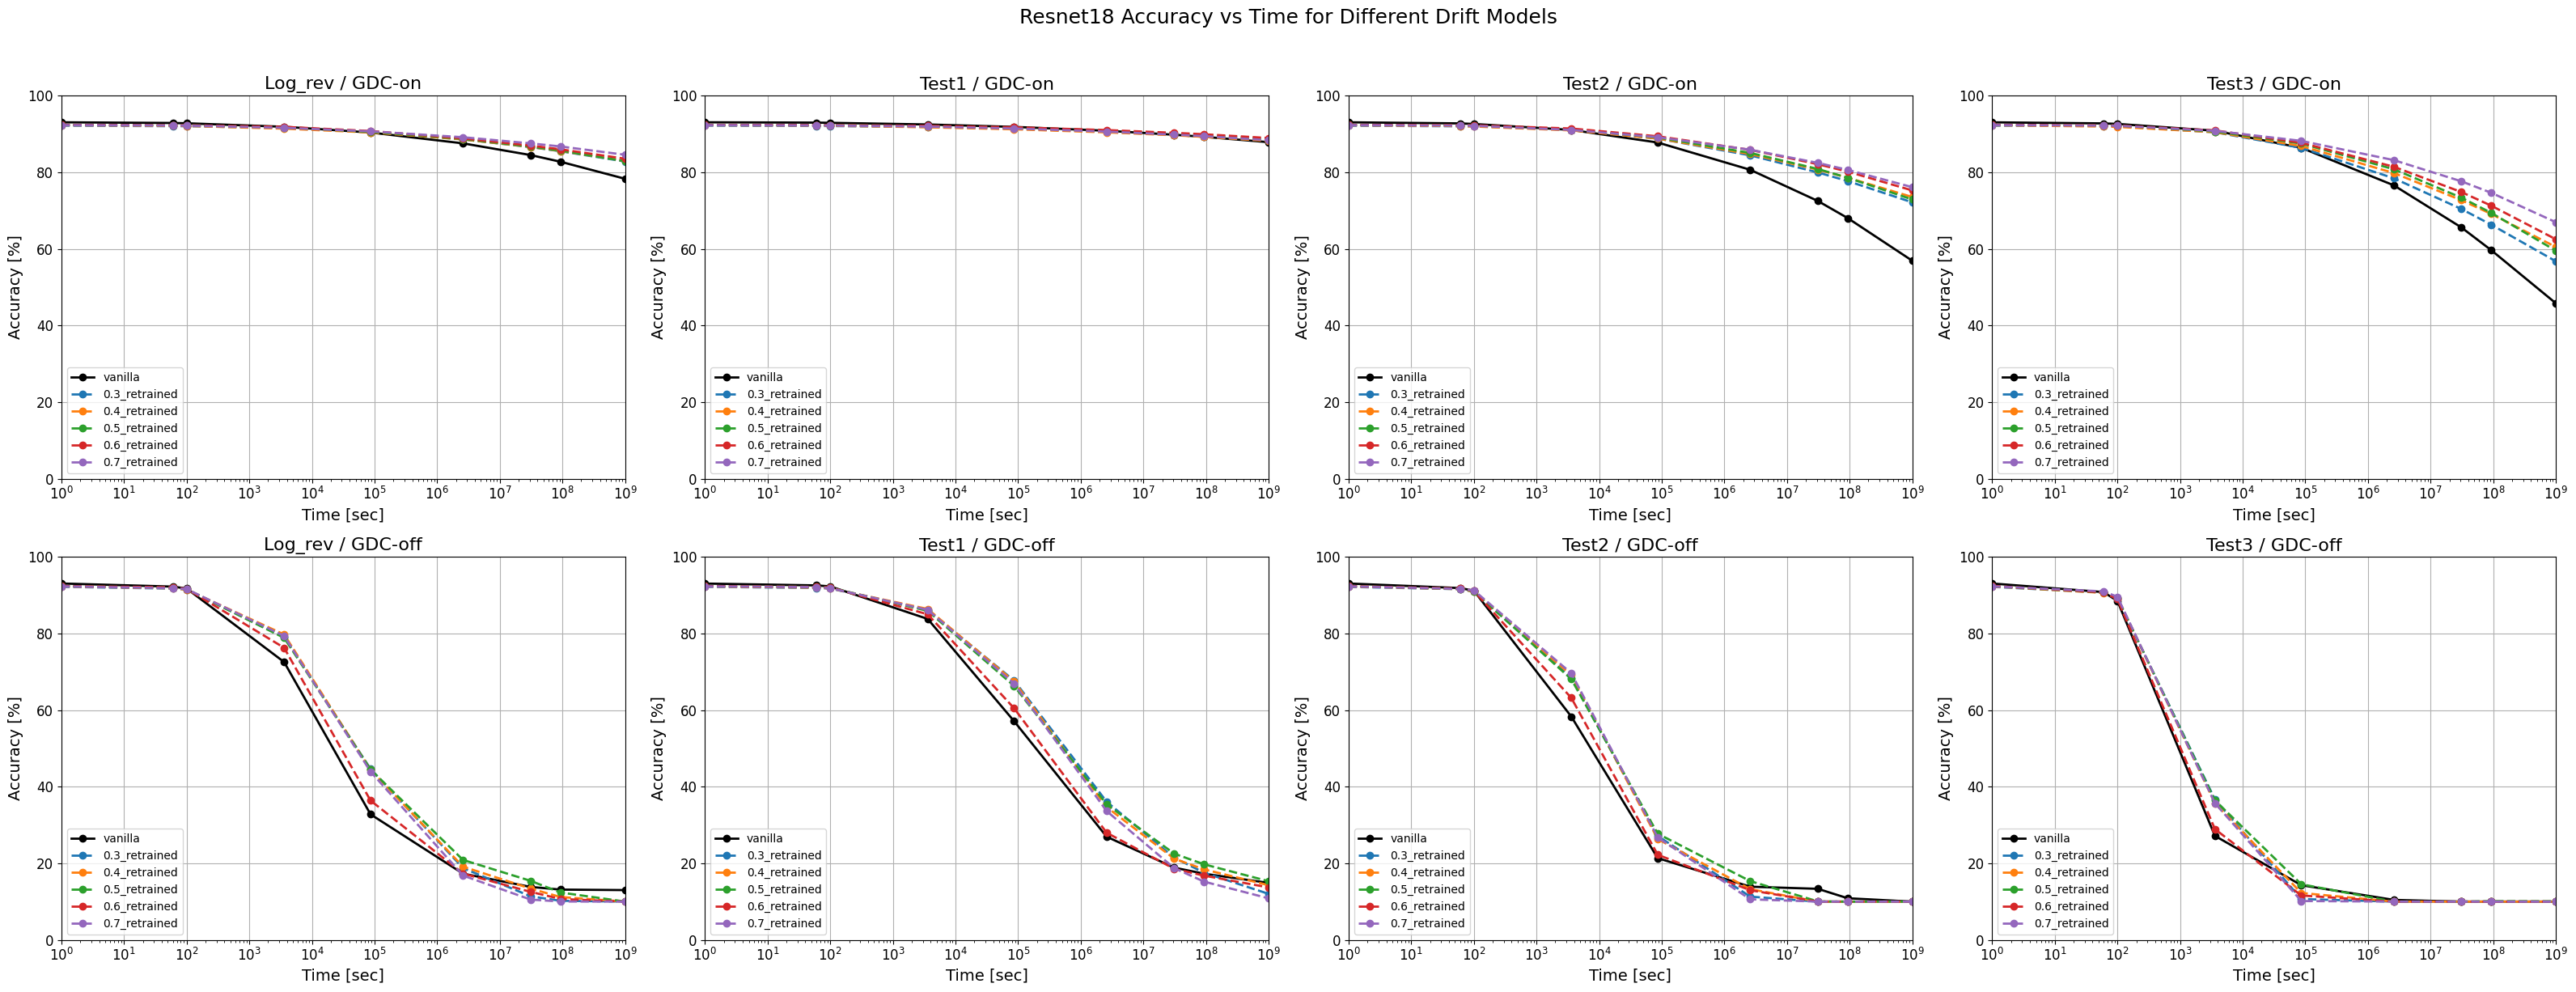

In [42]:
# Create figure with 3x2 subplots
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(32, 12))
plt.rcParams.update({'font.size': 12})

# Common plotting function
def plot_single_drift(ax, df_pivot, drift_model, title):
    x = df_pivot['inf_time']
    ls, marker = '-', 'o'  # Single style since we're plotting one drift model per subplot
    
    # Plot vanilla
    col_name = f'vanilla_{drift_model}'
    ax.plot(x, df_pivot[col_name], 
            label='vanilla', color='black',
            linestyle=ls, marker=marker, linewidth=2)
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        col_name = f'{ratio}_retrained_{drift_model}'
        ax.plot(x, df_pivot[col_name], 
                label=f'{ratio}_retrained',
                linestyle='--', marker=marker, linewidth=2)
    
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Accuracy [%]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1e9)
    ax.legend(fontsize=10, loc='lower left')

# Plot each condition
drift_models = ['log_rev', 'test1', 'test2', 'test3']
titles_gdc_on = ["Log_rev / GDC-on", "Test1 / GDC-on", "Test2 / GDC-on", "Test3 / GDC-on"]
titles_gdc_off = ["Log_rev / GDC-off", "Test1 / GDC-off", "Test2 / GDC-off", "Test3 / GDC-off"]

# Top row (GDC-on)
for ax, drift_model, title in zip([ax1, ax2, ax3, ax4], drift_models, titles_gdc_on):
    plot_single_drift(ax, df2_o_o_pivot, drift_model, title)

# Bottom row (GDC-off)
for ax, drift_model, title in zip([ax5, ax6, ax7, ax8], drift_models, titles_gdc_off):
    plot_single_drift(ax, df2_o_x_pivot, drift_model, title)


plt.suptitle("Resnet18 Accuracy vs Time for Different Drift Models", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [56]:
# Save pivot table to Excel
output_path = "drift_model_comparison_GDC_on.xlsx"
df2_o_o_pivot.to_excel(output_path, index=True, engine='openpyxl')
print(f"Saved to {output_path}")

Saved to drift_model_comparison_GDC_on.xlsx


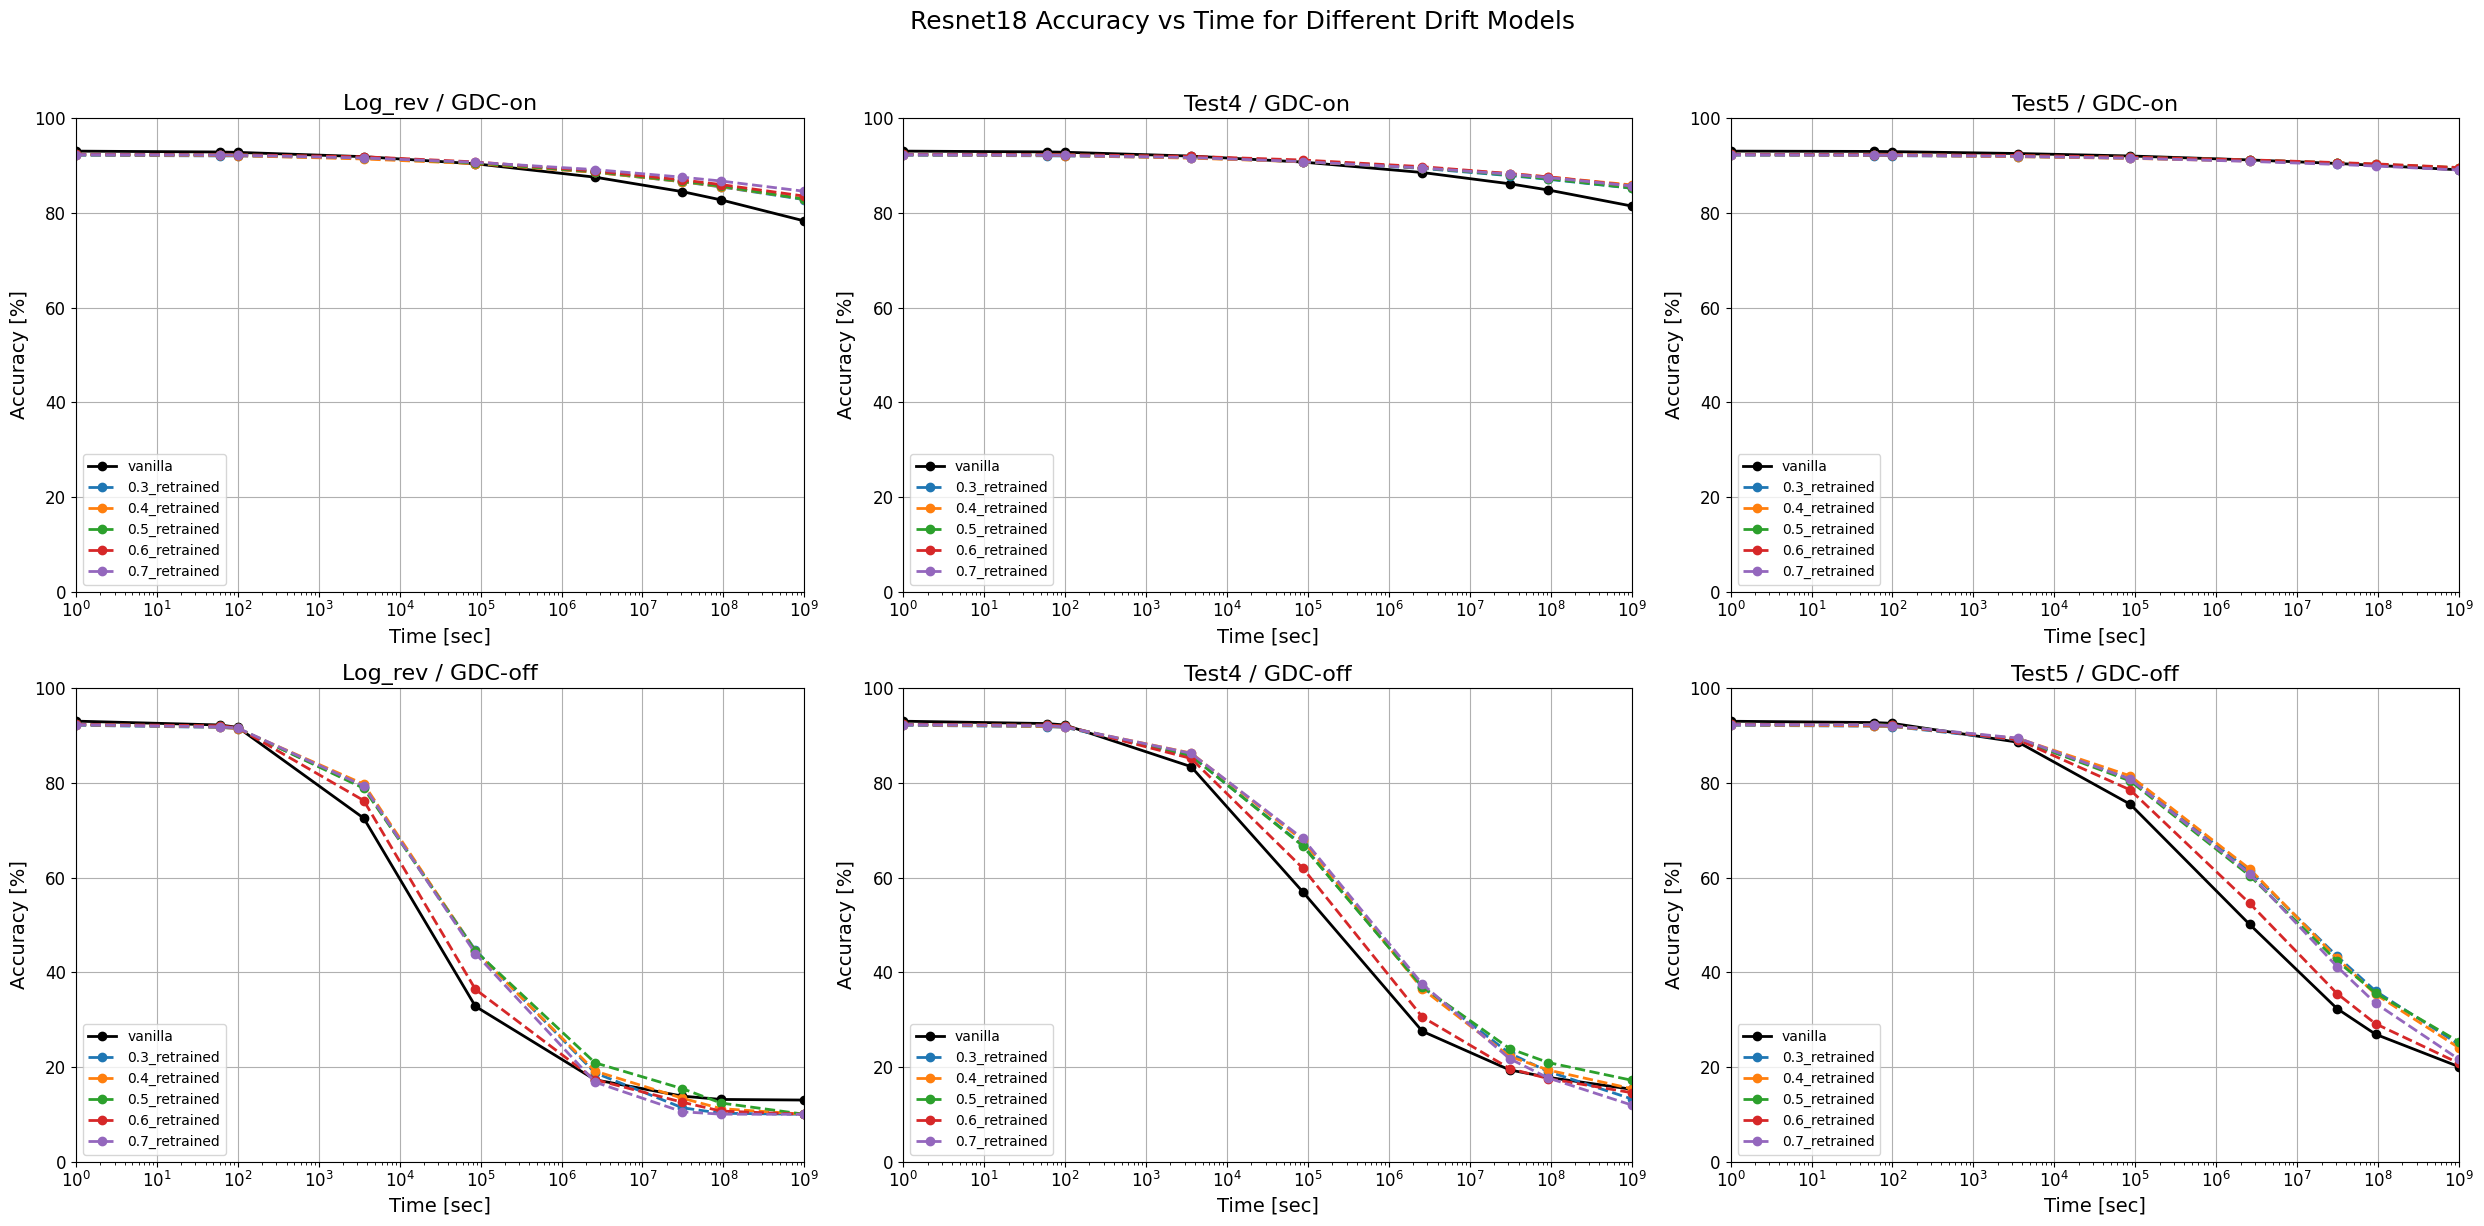

In [55]:
# Create figure with 3x2 subplots
fig, ((ax1, ax2, ax3), (ax5, ax6, ax7)) = plt.subplots(2, 3, figsize=(25, 12))
plt.rcParams.update({'font.size': 12})

# Common plotting function
def plot_single_drift(ax, df_pivot, drift_model, title):
    x = df_pivot['inf_time']
    ls, marker = '-', 'o'  # Single style since we're plotting one drift model per subplot
    
    # Plot vanilla
    col_name = f'vanilla_{drift_model}'
    ax.plot(x, df_pivot[col_name], 
            label='vanilla', color='black',
            linestyle=ls, marker=marker, linewidth=2)
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        col_name = f'{ratio}_retrained_{drift_model}'
        ax.plot(x, df_pivot[col_name], 
                label=f'{ratio}_retrained',
                linestyle='--', marker=marker, linewidth=2)
    
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Accuracy [%]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1e9)
    ax.legend(fontsize=10, loc='lower left')

# Plot each condition
drift_models = ['log_rev', 'test4', 'test5']
titles_gdc_on = ["Log_rev / GDC-on", "Test4 / GDC-on", "Test5 / GDC-on"]
titles_gdc_off = ["Log_rev / GDC-off", "Test4 / GDC-off", "Test5 / GDC-off"]

# Top row (GDC-on)
for ax, drift_model, title in zip([ax1, ax2, ax3], drift_models, titles_gdc_on):
    plot_single_drift(ax, df2_o_o_pivot, drift_model, title)

# Bottom row (GDC-off)
for ax, drift_model, title in zip([ax5, ax6, ax7], drift_models, titles_gdc_off):
    plot_single_drift(ax, df2_o_x_pivot, drift_model, title)


plt.suptitle("Resnet18 Accuracy vs Time for Different Drift Models", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()